## Riminder Technical Assessment
**Author: [Jorge Quintana](mailto:jorge.quintana.l@icloud.com)**
<br>
**Date: July 26th, 2018**
<hr>

### Problem Definition and Scope

Based on the challenge proposed by Riminder some definitions are detailed as follows to understand what is the scope of this notebook and how it can be extended.

Basically, the main task is to identify if a CV has logos of companies, icons, both or nothing. If so, extract the full information in each case. A big and super challenging task! However, the approach to be used here is smaller, in terms of scope, due to the lack of time and computational resources. Keeping that in mind, the approach to be taken here is described as follows:

   * Using the raw data, pictures of CV's with a label related to its content, create the data structures to pre-process, to analyze and to load those images
   * To perform some additional transformation (normalization, whitening, etc) regarding the further training and testing process
   * To split the whole data set into Training ans Testing samples to be used in posterior modeling stages
   * To train and to test some models to perform a classification task based on the content of the pictures
   * To evaluate the performance of the many specifications in terms of how effective can classify a picture according to its content
   
Hence, the scope of this task covers some of the initial phases in a common Data Science project (Data Understanding, Data Preparation, Data Transformation, Modeling and Evaluation) and following a modular schema, it provides a set if functions that can be easily extended regarding further explorations and experimentations. The whole process is defined below.

<hr>

## Set Up

Setting Up the whole environment to work with for the Computer Vision task. The version of the specific packages are shown below.

In [1]:
import warnings
warnings.filterwarnings("ignore")

import json
from os import listdir
from PIL import Image as PImage
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from skimage.transform import resize
from scipy import stats
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras

print("Numpy version: " + str(np.__version__))
print("Seaborn version: " + str(sns.__version__))
print("JSON version: " + str(json.__version__))
print("TensorFlow version: " + str(tf.__version__))

Numpy version: 1.14.3
Seaborn version: 0.8.0
JSON version: 2.0.9
TensorFlow version: 1.8.0


<hr>
## Data Exploration and Pre-processing

As an initial exploration step the sizes of each of the images are computed using the function **finding_sizes** and some statistics are computed. It is mandatory to define possible transformations to work with the dataset, for instance, if the images do not have the same size a resizing process should be defined or, according to the percentage of images with different size, define a subset if images to work with. The implementation of **finding_sizes** is shown below.

In [2]:
def finding_sizes():
    path = "riminder-test-vision-blanked-resumes-labelled/"
    images_list = listdir(path)
    n = []
    m = []

    for img in images_list:
        n.append(np.array(PImage.open(path + img)).shape[0])
        m.append(np.array(PImage.open(path + img)).shape[1])
    return n, m
    
n, m = finding_sizes()

Some descriptive statistics about the sizes are shown below.

MODE:
The mode for Height is: 840
The mode for Width is: 594
MIN:
The minimum for Height is: 335
The minimum for Width is: 533
MAX:
The maximum for Width is: 1200
The maximum for Width is: 1200


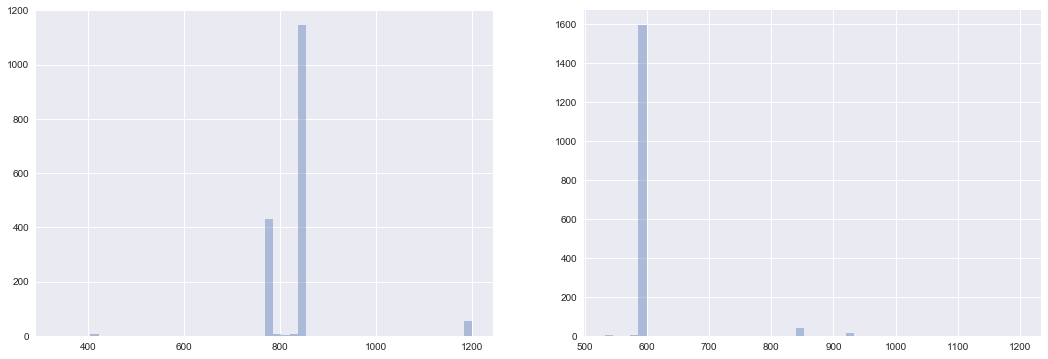

In [3]:
sns.set(color_codes = True)
f, axes = plt.subplots(1, 2)
f.set_size_inches(18, 6)

sns.distplot(n, kde = False, rug = False, ax = axes[0])
sns.distplot(m, kde = False, rug = False, ax = axes[1])

print("MODE:")
print("The mode for Height is: " + str(stats.mode(n)[0][0]))
print("The mode for Width is: " + str(stats.mode(m)[0][0]))

print("MIN:")
print("The minimum for Height is: " + str(min(n)))
print("The minimum for Width is: " + str(min(m)))

print("MAX:")
print("The maximum for Width is: " + str(max(n)))
print("The maximum for Width is: " + str(max(m)))

Thus, one conclusion can be extracted from this initial exploration process. Not all the images have the same sizes. The most common size is (840, 594, 3) and the largest and smallest images are (1200, 1200, 3) and (335, 533, 3), respectively. Based on that, a customized loading process should be defined for the following cases:
   
   * Load the whole dataset of images resizing them to fit the most common size ( **loading_option = 1** )
   * Load the whole dataset of images resizing them to fit the minimum size ( **loading_option = 2** )
   * Load the whole dataset of images resizing them to fit the maximum size ( **loading_option = 3** )
      
Those three cases imply the definition of some parameters for the **loading** function. Going beyond, while loading the images the label will be added to have the full information about each instance. To do so a function named **loading_and_labeling** is implemented as follows.

In [4]:
def load_and_label(images, label, cont, n, m):
    
    """
    This function implements a simple logic to load the dataset according to the defined possible cases. 
    It takes 5 arguments: 
    
    * images: a list in which images will be saved
    * label: a list in which labels will be saved
    * cont: an auxiliar variable to count the number of images processed
    * n, m: the dimensions to resize the images
        
    As output this function returns two Numpy Arrays: 
    
    * images with (n, m, 3) shape
    * label with (n, 1) shape
    """
    
    path = "riminder-test-vision-blanked-resumes-labelled/"
    images_list = listdir(path)
    
    with open("riminder-test-vision-blanked-resumes-labels.json", "r") as read_file:
        labels = json.load(read_file)
        read_file.close()
        
    print("Loading and resizing images..." + str([n, m, 3]))
    for img in images_list:
        image = np.array(PImage.open(path + img))
        image = resize(image, (n, m, 3))
        images.append(image)
        label.append(labels[img])
        cont += 1

    label = np.array(label)
    images = np.vstack(images).reshape([cont, n, m, 3])
    images = images.astype(np.float32, copy = False)
    return images, label

Using **starting_parameters** and **loading_and_labeling** functions the loading and resizing process of the whole dataset to the minimum size (335, 533, 3 ( *loading_option = 3* ) is executed as follows. Both arrays, images and label, are being saved in disk to avoid further recomputations and to optimize the memory usage.

In [5]:
def starting_parameters(loading_option):
    
    """
    This function initializes the arguments needed to execute the loading_and_labeling function. As input it receives
    one argument: loading_option and returns the following objects:
    
    * images: A list in which images will be saved
    * label: A list in which labels will be saved
    * cont: A counter of the images saved
    * n_, m_: Height and Width to use in the resizing process. They depend on loading_option
    """
    
    images = []
    label = []
    cont = 0
    
    if loading_option == 1:
        n_ = stats.mode(n)[0][0]
        m_ = stats.mode(n)[1][0]
    elif loading_option == 2:
        n_ = max(n)
        m_ = max(m)
    else:
        n_ = min(n)
        m_ = min(m)
    return images, label, cont, n_, m_

loading_option = 3
images, label, cont, n_, m_ = starting_parameters(loading_option = loading_option)
images, label = load_and_label(images = images,
                               label = label,
                               cont = cont,
                               n = n_,
                               m = m_)

print("Number of images loaded and labeled: " + str(len(images)))
#np.savez('images.npz', images)
#np.savez('label.npz', label)

Loading and resizing images...[335, 533, 3]
Number of images loaded and labeled: 1655


Now, the next task is to create the label array which encodes the information of original labels. There are four levels for labels: **nothing**, **has_icon**, **has_company** and **has_both**. Based on that, and on the label provided, a vector is created with the following logic.

Let be p an ith-picture in the dataset. Thus, 

   * $Label_i = [1, 0, 0, 0]$ if p has nothing inside. On the other hand,  
   * $Label_i = [0, 1, 0, 0]$ if p has an icon
   * $Label_i = [0, 0, 1, 0]$ if p has a company logo and
   * $Label_i = [0, 0, 0, 1]$ if p has both. 

The implementation is as follows and the final shape of the array is shown below.

In [6]:
def encoder(x):
    
    """
    This function implements the logic for the encoding process of labels. Based on the logic previously defined
    an array is created for each instance according to the value of its label. This function receives an argument x,
    which is each instance, and returns y, the array with the encoded label
    """
    
    if x == "nothing":
        y = [1, 0, 0, 0]
    elif x == "has_icon":
        y = [0, 1, 0, 0]
    elif x == "has_company":
        y = [0, 0, 1, 0]
    else:
        y = [0, 0, 0, 1]
    return y

label_encode = np.array(list(map(lambda x: encoder(x), label)))
print("Size of Labels Encoded: " + str(label_encode.shape))
np.savez('label_encode.npz', label_encode)

Size of Labels Encoded: (1655, 4)


Now, having all the pictures with the same dimensions and the label encoded, the next step is to split into training and testing samples. After that, to normalize the RGB values. To do so, each entry will be divided by 255. The process is implemented as follows.

In [7]:
X_train, X_test, labels_train, labels_test = train_test_split(images, label_encode, test_size = 0.2, random_state = 42)

print("Features for Training (size): " + str(X_train.shape))
print("Features for Testing (size): " + str(X_test.shape))
print("Labels for Training (size): " + str(labels_train.shape))
print("Labels for Training (size): " + str(labels_test.shape))

del images, label_encode, label

Features for Training (size): (1324, 335, 533, 3)
Features for Testing (size): (331, 335, 533, 3)
Labels for Training (size): (1324, 4)
Labels for Training (size): (331, 4)


In [8]:
X_train /= 255.0
X_test /= 255.0

<hr>
## Training and Testing Process

Based on the dataset provided and after carefully manipulation and pre-processing to create a training and testing datasets (for features and labels) the modeling task is splitted into two parts: First, using **Shallow and Fully Connected Neural Networs** and second, using **Convolutional Neural Networks**. The whole process description is presented as follows.

### Shallow Fully Connected Neural Networks

Three Shallow Neural Networks will be trained using simple architectures to classify images according to the labels encoded before. Hence, the NN will be able to classify pictures which contains **nothing** (No companies' logos nor icons) or contains **icons** or contains **companies** or **both**.

Regarding the architectures of the NN's, all NN's will include a ***Flatten*** layer as a way to put together all the normalized RGB values. After that, the first NN will have one **Dense Layer (Fully Connected)** with an ***ReLu*** activation function and one more ***Dense Layer (Fully Connected)*** using a ***Softmax*** activation function to generate the final output. The second NN will add one more hidden layer, a **Dense Layer (Fully Connected)** and the third one will include one more hidden layer, a **Dense Layer (Fully Connected)** (Both layers will have a **ReLu** activation function). 

In terms of model compilation, **Adam** algorithm is used as optimizer and, based on the shape of the labels, a **categorical_crossentropy** loss function is used. Moreover, a **validation proportion of 20%** is used during the training process and **Accuracy** will be the metric to evaluate the performance of the models, on Training and on Testing Samples. The implementation, based on some functions definition, is shown below.

In [10]:
def def_model(n_, m_, layers, hidden_units):
    
    """
    This function defines the model to be trained based on the parameters that can be specified. It receives 4
    parameters which defines the NN architecture.
    
        * n_, m_: Are the height and width of the images. Is one of the parameters for the flatten layer.
        * layers: Defines the number of layers of the model
        * hidden_units: Defines the number of hidden units in each layer
        
    Those parameters let customize the creation of models regarding a Cross Validation process
    """
    
    if layers != len(hidden_units):
        print("Wrong numbers of units and layers")
    else:
        if layers == 1:
            model = keras.Sequential([
                keras.layers.Flatten(input_shape = (n_, m_, 3)),
                keras.layers.Dense(hidden_units[0], activation = tf.nn.relu),
                keras.layers.Dense(4, activation = tf.nn.softmax)
            ])
        elif layers == 2:
            model = keras.Sequential([
                keras.layers.Flatten(input_shape = (n_, m_, 3)),
                keras.layers.Dense(hidden_units[0], activation = tf.nn.relu),
                keras.layers.Dense(hidden_units[1], activation = tf.nn.relu),
                keras.layers.Dense(4, activation = tf.nn.softmax)
            ])
        elif layers == 3:
            model = keras.Sequential([
                keras.layers.Flatten(input_shape = (n_, m_, 3)),
                keras.layers.Dense(hidden_units[0], activation = tf.nn.relu),
                keras.layers.Dense(hidden_units[1], activation = tf.nn.relu),
                keras.layers.Dense(hidden_units[2], activation = tf.nn.relu),
                keras.layers.Dense(4, activation = tf.nn.softmax)
            ])
        else:
            print("Architecture not defined!")

        model.compile(optimizer = tf.train.AdamOptimizer(), 
                      loss = "categorical_crossentropy",
                      metrics = ["accuracy"])
    return model

In [32]:
def train_model(model, X_train, labels_train, epochs, batch_size):
    
    """
    This function trains one model, which is received as one of the parameters, and customized the process based
    on the parameters defined such as:
    
        * epochs: Defines the number of epochs during the training process
        * batch_size: Defines the batch size during the training process
        
    As output the history of the training process is returned
    """
    
    training_results = model.fit(X_train,
                                 labels_train,
                                 validation_split = 0.2,
                                 epochs = epochs,
                                 batch_size = batch_size,
                                 verbose = False)
    return training_results

In [12]:
def eval_model(model, X_test, labels_test):
    
    """
    This function evaluates a trained model using X_test to compute the predicted labels and labels_test as real
    labels. As output it prints the Accuracy of the model.
    """
    
    _, test_acc = model.evaluate(X_test, labels_test)
    print("Test Accuracy:", test_acc)

In [13]:
def plot_results(training_results):
    
    """
    This function plots the achieved performance (Accuracy) of the model during the training process
    """
    
    plt.figure(figsize = (18, 6))
    plt.plot(training_results.history['acc'])
    plt.plot(training_results.history['val_acc'])
    plt.title("Model Accuracy")
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.legend(["Train", "Test"], loc = "bottom left")
    plt.show()

### Architecture # 1: One Hidden Layer


Architecture with 1 layer and 512 hidden units


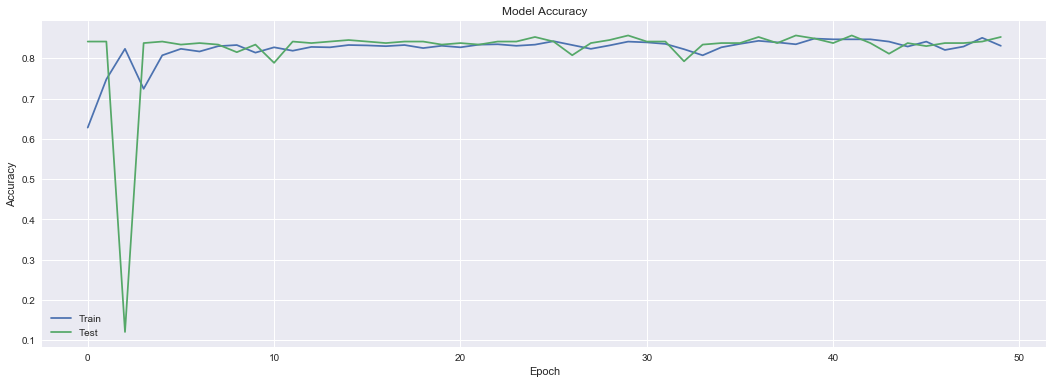

331/331 [==============================] - 4s 13ms/step
Test Accuracy: 0.8398791538984753

Architecture with 1 layer and 256 hidden units


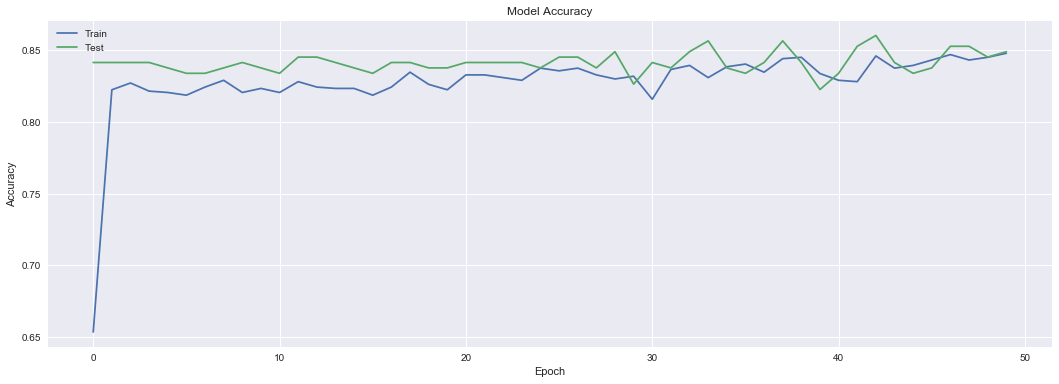

331/331 [==============================] - 2s 7ms/step
Test Accuracy: 0.8489425980072367

Architecture with 1 layer and 128 hidden units


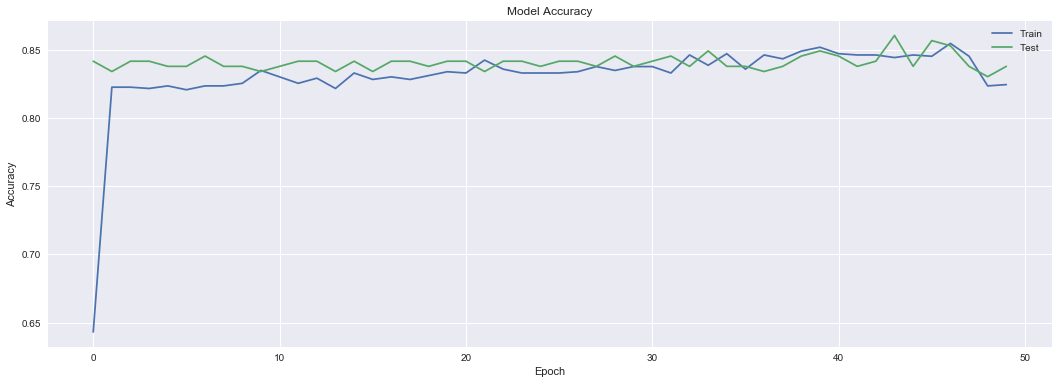

331/331 [==============================] - 2s 6ms/step
Test Accuracy: 0.854984895160191


In [13]:
for hu in [512, 256, 128]:
    print("\nArchitecture with 1 layer and "  + str(hu) + " hidden units")
    model = def_model(n_ = n_, m_ = m_, layers = 1, hidden_units = [hu])
    training_results = train_model(model, X_train, labels_train, epochs = 50, batch_size = 128)
    plot_results(training_results)
    eval_model(model, X_test, labels_test)

### Results:

The results for the 1 hidden layer NN's show that best results are coming from the NN with 128 hidden units with a Testing Accuracy of 85%. The plots show that Training Accuracy is getting better as epochs increase and Validation Accuracy is almost constant from the beginning (This is al common issue and can be explained for the lack of researching and iterating in Tuning Hyperparameters Process).

### Architecture # 2: Two Hidden Layer

Architecture with 2 layers and [512, 64] hidden units


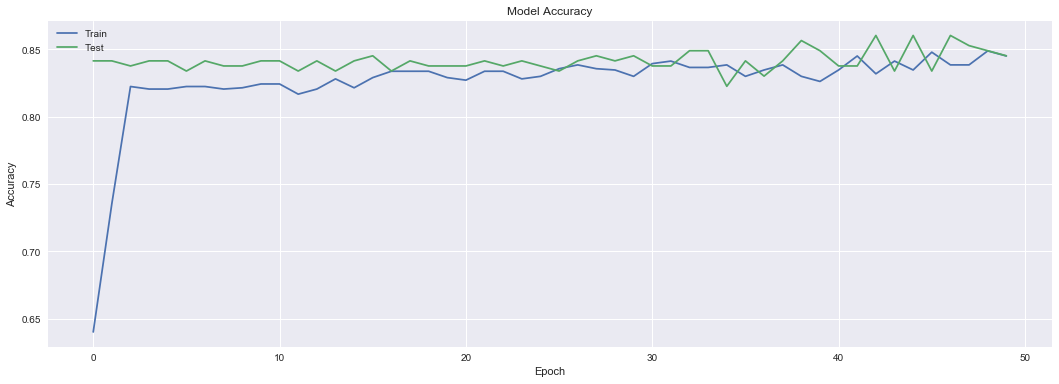

331/331 [==============================] - 4s 12ms/step
Test Accuracy: 0.8519637471239372
Architecture with 2 layers and [512, 128] hidden units


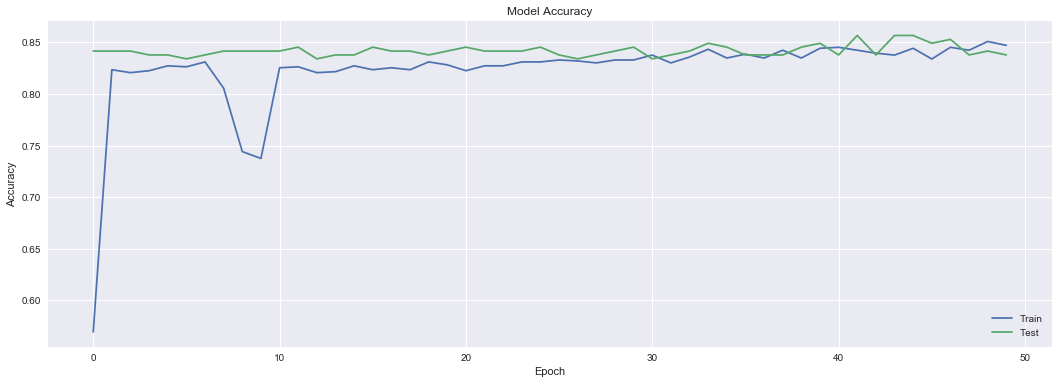

331/331 [==============================] - 4s 13ms/step
Test Accuracy: 0.8157099696084452
Architecture with 2 layers and [256, 64] hidden units


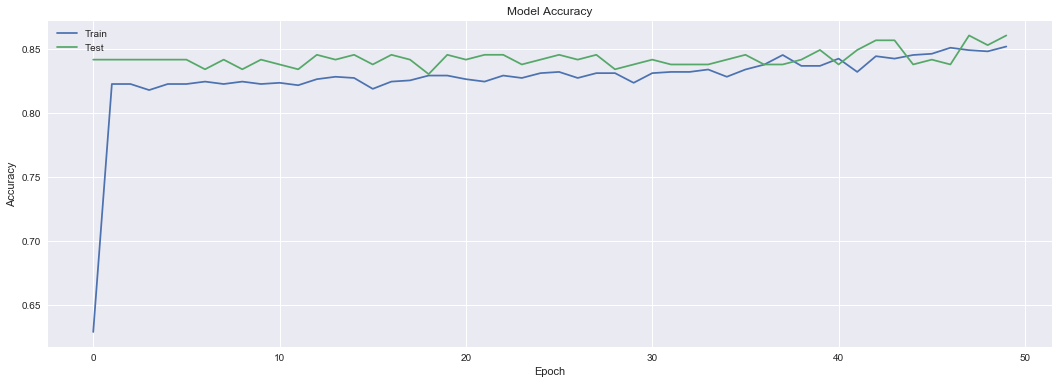

331/331 [==============================] - 2s 7ms/step
Test Accuracy: 0.8398791538984753
Architecture with 2 layers and [256, 128] hidden units


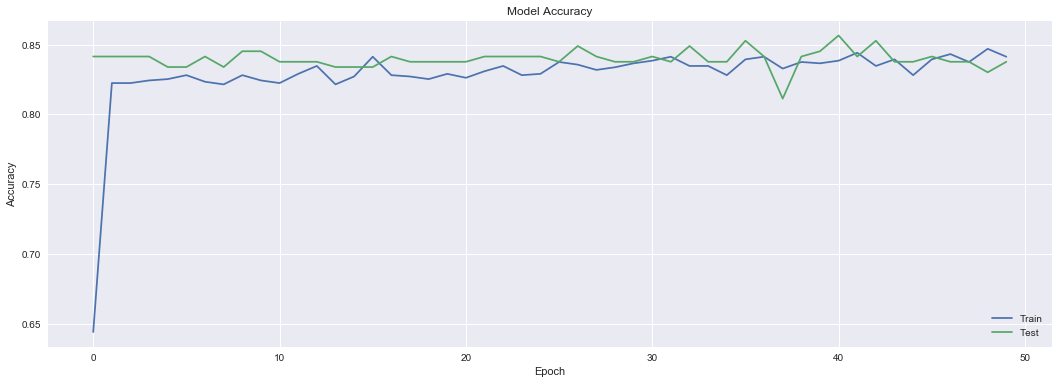

331/331 [==============================] - 2s 7ms/step
Test Accuracy: 0.8157099696084452


In [14]:
for hu1 in [512, 256]:
    for hu2 in [64, 128]:    
        print("\nArchitecture with 2 layers and ["  + str(hu1) + ", " + str(hu2) + "] hidden units")       
        model = def_model(n_ = n_, m_ = m_, layers = 2, hidden_units = [hu1, hu2])
        training_results = train_model(model, X_train, labels_train, epochs = 50, batch_size = 128)
        plot_results(training_results)
        eval_model(model, X_test, labels_test)

### Results:

For the 2 hidden layers NN's the results are similar to previous ones. The best NN is which has (512, 64) hidden units in each hidden layer. The Testing accuracy for that NN is 85% and the same commnet about the dynamic of Training Accuracy and Validation Accuracy holds here.

### Architecture # 3: Three Hidden Layer

In [ ]:
for hu1 in [1024, 512]:
    for hu2 in [264, 128]:
        for hu3 in [32, 64]:
            print("\nArchitecture with 3 layers and ["  + str(hu1) + ", " + str(hu2) + ", " + str(hu3) + "] hidden units")
            model = def_model(n_ = n_, m_ = m_, layers = 3, hidden_units = [hu1, hu2, hu3])
            training_results = train_model(model, X_train, labels_train, epochs = 10, batch_size = 128)
            plot_results(training_results)
            eval_model(model, X_test, labels_test)

### Results:

For the 3 hidden layers NN's the results are not shown because of two reasons. First, it took a lot of time to train the (1024, 264, 32) hidden units and second, the results were not better than the 2 layers NN. Further experimentations can be address to identify if such architecture can have a higher performance, but for this more computational resources are mandatory.

Finally, regarding the **Shallow Fully Connected Neural Networks** the best performance was achieved using a simple and shallow architecture. In terms of performance, the best two NN's were 1 hidden layer with 128 units followed by 2 hidden layers with (512, 64) hidden units.

**TO DO:**

Some possible extensions can be done to test if those architectures can achieved better performance. For instance, adding more data using some artificially generated process, for instance, generating more instances using some transformations of the current images (Random Flipping, Rotation, etc) and, finally, trying some refinements for the training process such as regularization, a more exhaustive Hyper-Parameters Tuning Process and some experimentations with different optimizers, initializers, etc. *(The way in which those values were chosen was following some previous experience but a more carefull definition process, based on experimentation and iteration, should be performed)*

## Convolutional Neural Networks

As an alternative approach a simple CNN is trained using the following architecture:

   * Two Convolutional Layer {l = (1, 4)} using (10, 4) as filters and (7, 5) as kernel sizes. Both are using ReLu activation functions.
   * One Pooling Layer {l = 2} using MaxPooling with a pool size of (2, 2)
   * One Dropout layers {l = 3} using as rate 0.25
   * One Flatten Layer {l = 5}
   * One Dense Layer {l = 6} with 4 units and using a Softmax activation function.
   
Moreover, as Loss Function **categorical_crossentropy** is used, basically because of the shape of the labels. The metric to evaluate the CNN is **Accuracy**, the same used in previous NN's. And as optimizer a **Stochastic Gradient Descent** with a **Learning Rate** of 0.001 with **Decay** of 1e-6 and **Momentum** of 0.8 is being used. *(This hyper-parameters were chosen following previous experience but should be tested in a more carefully to assure that are the best for this particular task)*

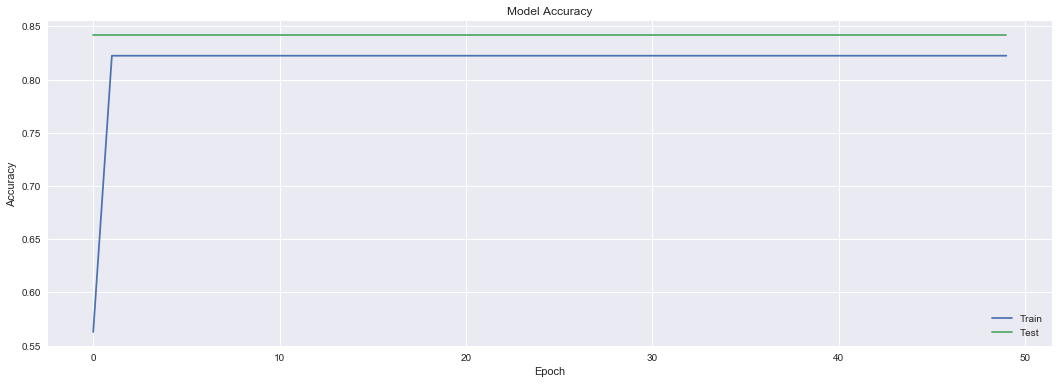

331/331 [==============================] - 10s 31ms/step
Test Accuracy: 0.8096676735359376


In [36]:
model = keras.Sequential()
model.add(keras.layers.Convolution2D(10, kernel_size = 7, strides = (2, 2), activation = "relu"))
model.add(keras.layers.MaxPooling2D((2, 2)))
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Conv2D(4, kernel_size = 5, activation = "relu"))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(4, activation = "softmax"))

model.compile(loss = "categorical_crossentropy",
              metrics = ["accuracy"],
              optimizer = keras.optimizers.SGD(lr = 0.001,
                                               decay = 1e-6,
                                               momentum = 0.8))

training_results = model.fit(X_train,
                             labels_train,
                             batch_size = 128,
                             epochs = 50,
                             validation_split = 0.2,
                             shuffle = True,
                             verbose = False)

plot_results(training_results)
eval_model(model, X_test, labels_test)

### Results

Many experiments were done making some modifications in the architecture and in the compilation of the model, for instance, using RMSprop as optimizer equivalent results were achieved and changing the number of filter in the Convolutional and Pooling layers. A big issue related to the performance of the model is related to number of filters and the size of the kernels using in the Convolutional layers. Basically, the lack of computational resources do not let to improve the results because more filters cannot be added and more layers neither. *Only 8GB of RAM and no GPU were available!*

Regarding the results of CNN, the Testing Accuracy is lower than previous models and the plot of the Training and Validation Accuracy does not make too much sense.

<hr>

### Conclusions and Possible Extensions

After some brief experimentations with different architectures the performance can be improved with a more exhaustive Hyper-Parameters tuning process, adding more and better data (in this case the whole dataset was resized to fit the minimum size, which reduces the quality of the images) and trying some experimentation to define the optimizers and even the initializers which was not possible for time constraints and for lackness of resources.

Regarding the data quality, some extensions can be done to increase the richness of the dataset such as syntethic data generation and more powerful architecture for image classification and object recognition.